In [11]:
import os
import pickle
import random
import glob
import datetime
import pandas as pd
import numpy as np
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
from PIL import Image
import cv2
#from focal_loss import sparse_categorical_focal_loss
import keras
#import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3

# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from keras.optimizers import SGD
from keras import backend

from keras.preprocessing import image
import albumentations as A


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [8]:
base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train/'
TEST_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_test/'
image_dir = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/png/train/adjacent-brain-cropped/'
save_dir = 'home/ubuntu/kaggle/models/'
os.listdir(base_url)

def png(image): 
    return image + '.png'

# focus_loss

In [76]:

#model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[weighted_loss])
#model.compile(optimizer=SGD(lr=learning_rate, momentum=0.9), loss=[focal_loss(6)], metrics=['accuracy'])
#model.compile('sgd', loss=tf.keras.losses.SigmoidFocalCrossEntropy())

In [73]:

decay_steps = 1000
initial_learning_rate = 1e-2
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate, decay_steps)

opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

# weighted_metrics

In [9]:
from keras import backend as K
def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

# Data Generator

In [109]:
train_idg = ImageDataGenerator(rotation_range=360,
        horizontal_flip=True,
        validation_split=0.15,
        rescale=1./255)
valid_idg = ImageDataGenerator()
training_data = pd.read_csv(f'train_0.csv') 
training_data['Image'] = training_data['Image'].apply(png)

validation_data = pd.read_csv(f'valid_0.csv')
validation_data['Image'] = validation_data['Image'].apply(png)

columns=['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']

train_data_generator = train_idg.flow_from_dataframe(training_data, directory = image_dir,
                           x_col = "Image", y_col = columns,batch_size=64,
                           class_mode="raw", target_size=(224,224), shuffle = True)
valid_data_generator  = valid_idg.flow_from_dataframe(validation_data, directory = image_dir,
                        x_col = "Image", y_col = columns,batch_size=64,
                        class_mode = "raw",target_size=(224,224), shuffle = False)

Found 600937 validated image filenames.
Found 151865 validated image filenames.


# Model

In [26]:
from keras.applications.inception_v3 import InceptionV3

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]







# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes

#initializer = keras.initializers.GlorotUniform()
#layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

predictions = Dense(6, activation='sigmoid')(x)
#activation='sigmoid',kernel_initializer=keras.initializers.GlorotNormal()
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[weighted_loss,auc,'accuracy'])
#model.compile(loss=loss_func,
#          optimizer=opt,
#          metrics=METRICS)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_565 (Conv2D)             (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, 111, 111, 32) 96          conv2d_565[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, 111, 111, 32) 0           batch_normalization_565[0][0]    
__________________________________________________________________________________________________
conv2d_566

# Callbacks

In [18]:
batch_size=32
learning_rate=5e-4
num_epochs=5
decay_rate=0.8
decay_steps=1
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.5,
                                           patience=2,
                                           min_lr=1e-8,
                                           mode="min")

scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: learning_rate * pow(decay_rate, floor(num_epochs / decay_steps)))
Checkpoint= keras.callbacks.ModelCheckpoint(f"Enet_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
       save_weights_only=True,mode='max')
callback_list=[Checkpoint]

# This saves the best model
#checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'InceptionResNetV2_0', 
#                        monitor='val_accuracy', verbose=1, 
#                        save_best_only=True, mode='max')
#callbacks_list = [checkpoint]



# LOAD BEST MODEL to evaluate the performance of the model
#model.load_weights("/saved_models/model_"+str(fold_var)+".h5")


# Model Fit

In [36]:



num_epochs = 3

batch_size = 1000
training_steps = len(training_data) // batch_size
validation_step = len(validation_data) // batch_size




# FIT THE MODEL
history = model.fit_generator(train_data_generator,
            epochs=num_epochs,steps_per_epoch=training_steps,
            callbacks=callback_list,
            validation_data=valid_data_generator,
            validation_steps= validation_step) 





tf.keras.backend.clear_session()



Epoch 1/3
600/600 [==============================] - 740s 1s/step - loss: 0.1567 - weighted_loss: 0.1788 - auc: 0.8486 - acc: 0.9472 - val_loss: 0.1912 - val_weighted_loss: 0.2191 - val_auc: 0.8520 - val_acc: 0.9430
Epoch 2/3
  2/600 [..............................] - ETA: 1:00 - loss: 0.2008 - weighted_loss: 0.2268 - auc: 0.8488 - acc: 0.9284

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


600/600 [==============================] - 723s 1s/step - loss: 0.1562 - weighted_loss: 0.1778 - auc: 0.8540 - acc: 0.9469 - val_loss: 0.1716 - val_weighted_loss: 0.1962 - val_auc: 0.8574 - val_acc: 0.9460
Epoch 3/3
600/600 [==============================] - 722s 1s/step - loss: 0.1537 - weighted_loss: 0.1751 - auc: 0.8599 - acc: 0.9473 - val_loss: 0.1713 - val_weighted_loss: 0.1978 - val_auc: 0.8619 - val_acc: 0.9428


In [63]:
predict = model.evaluate_generator(valid_data_generator,steps=validation_step)

In [134]:
print('\n---------------\n')
print('validation data **loss** value =', predict[0])
print('\n---------------\n')
print('validation data **weighted_loss** value = ', predict[1])
print('\n---------------\n')
print('validation data **AUC** value =',predict[2])
print('\n---------------\n')
print('validation data **accuracy** value =',predict[2])
print('\n---------------\n')


---------------

validation data **loss** value = 0.16912455615026273

---------------

validation data **weighted_loss** value =  0.19489387107013867

---------------

validation data **AUC** value = 0.8610175129593602

---------------

validation data **accuracy** value = 0.8610175129593602

---------------



In [104]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure(figsize = (10,10))
        plt.plot(H.epoch,H.history["acc"], label="train_acc")
        plt.plot(H.epoch,H.history["val_acc"], label="val_acc")
        plt.title("Training Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
        plt.show()

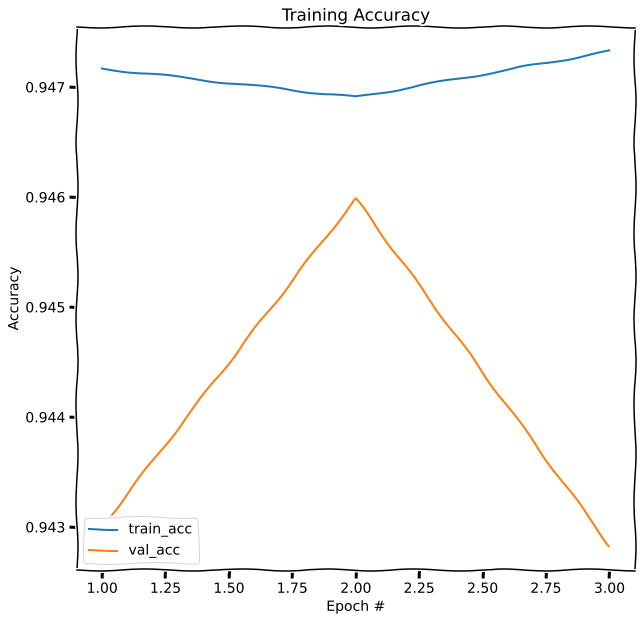

In [105]:
plot_training(history)

In [106]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure(figsize = (10,10))
        plt.plot(H.epoch,H.history["loss"], label="train_loss")
        plt.plot(H.epoch,H.history["val_loss"], label="val_loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        plt.show()

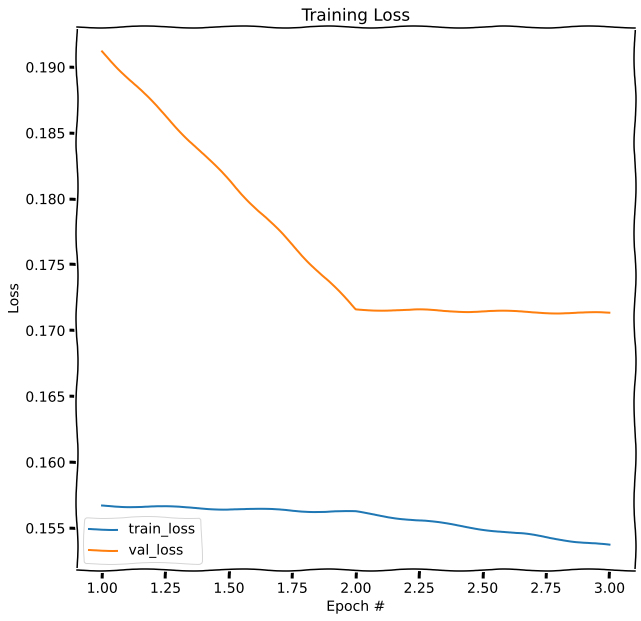

In [107]:
plot_training(history)

In [95]:
def plot_metrics(history):
    plt.figure(figsize = (15,15))
    metrics =  ['loss', 'auc']
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        
        plt.plot(history.epoch,  history.history[metric], color='red', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='orange', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

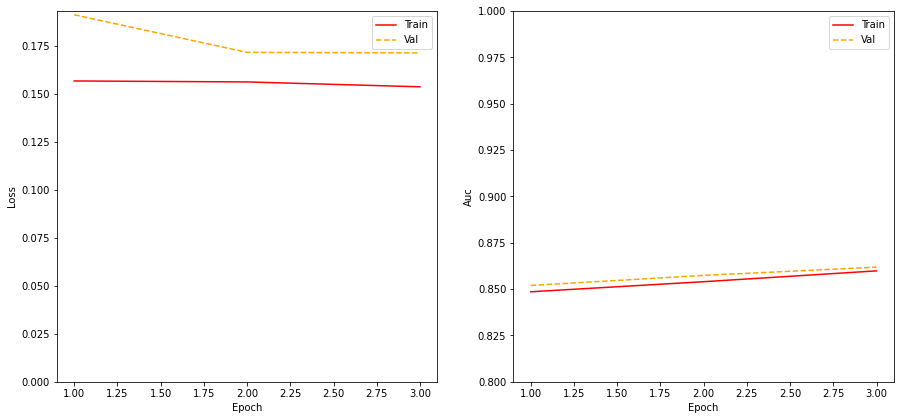

In [96]:
plot_metrics(history)